In [ ]:
#####################################################################################################
# Author: Stefano Fernando Panzeri Reyes                                                            #
# Master Thesis: Data Analysis and Modelling of Induction Hardening Processes                       #
# Collaborators: USN and ENRX                                                                       #
# Year: 2023                                                                                        #     
# License: MIT License (see the LICENSE file for the full license text)                             #
# Python Version: 3.10                                                                              #             
# Description: Development of an LSTM model for error prediction.                                   #
#              - Prediction of DC Voltage Too Low by analysing the first 10 seconds of hardening.   #
#####################################################################################################

RELEVANT IMPORTS

In [2]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Importing ML Vectors

In [3]:
importing_folder = os.path.join(os.getcwd(),'LSTM_Files/LSTMVectors/Case1')
x_train_transformed = np.load(os.path.join(importing_folder,'x_trainCase1_transformed.npy'))
y_train = np.load(os.path.join(importing_folder,'y_trainCase1.npy'))
x_validation_transformed = np.load(os.path.join(importing_folder,'x_validationCase1_transformed.npy'))
y_validation = np.load(os.path.join(importing_folder,'y_validationCase1.npy'))
x_test_transformed = np.load(os.path.join(importing_folder,'x_testCase1_transformed.npy'))
y_test = np.load(os.path.join(importing_folder,'y_testCase1.npy'))

MODEL DEVELOPMENT

Definition of Relevant Functions

In [14]:
def model_setup(num_hidden_layers, num_neurons, activation_function, input_shape, output_shape):
    """
    Function to create a dynamic LSTM model, according to input parameters
    
    :param num_hidden_layers: Integer number of hidden layers (not counting input and output layer)
    :param num_neurons:  List containing number of neurons per layer
    :param activation_function: String containing activation function name for hidden layers
    :param input_shape: List containing th shape of input
    :param output_shape: List containing th shape of output
    :return: Compiled Sequential LSTM model
    """
    # Definition of model metrics
    precision = keras.metrics.Precision(name='precision')
    recall = keras.metrics.Recall(name='recall')
    
    model_LSTM = Sequential()  # Creation of empty Keras Sequential Model
    for i in range(num_hidden_layers):  # Iterate over number of hidden layers
        # Neurons in each layer are according to the number of the layer
        if i == 0: # First layer must have input shape and Return Sequences to True
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function,input_shape=(input_shape[1],input_shape[2]), return_sequences=True))
        elif i == num_hidden_layers -1: # Last layer must have Return Sequences to False (no need to output all the hidden states)
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function))
        else: # Middle layers have Return Sequences to True
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function,return_sequences=True))

    model_LSTM.add(Dense(units = output_shape[1], activation='sigmoid')) # Dense layer output with Sigmoid as Activation Function (binary classification)
    model_LSTM.compile(optimizer='adam', loss='mse', metrics=[precision, recall])  # Compiling using adam, Mean Square Error as loss and the two defined metrics
    return model_LSTM


def plot_training(history, type_graph, saving=False, saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1')):
    """
    Function to Plot the Performance Metric during the training of the model
    
    :param history: Object variable containing history from model training
    :param type_graph: String with metric to plot
    :param saving: Boolean value indicating if needed to save the created figure 
    :param saving_path: String indicating the path to save the created figure
    :return: NO RETURN
    """
    fig = plt.figure()  # create new figure
    plt.plot(history.epoch,history.history[type_graph])  # Plot the history of the selected metric for training dataset
    plt.plot(history.epoch,history.history['val_' + type_graph])  # Plot the history of the selected metric for validation dataset (in same figure)
    plt.legend(['Training Set', 'Validation Set'])  # Legend to indicate which curve correspond to each dataset
    # Add corresponding labels
    plt.ylabel(type_graph + ' score')
    plt.xlabel('epoch')
    # Add title according to the metric plotted
    name= 'Model ' + type_graph 
    plt.title(name)
    if saving:  # Saving figure locally
        os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
        fig.savefig(os.path.join(saving_path, name +  ' Case 1.png'), format='png', dpi=600, transparent=True)
    plt.show()
    
def plot_prediction(y_predicted, y_test, saving=False, saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1')):
    """ 
    Function to Plot the Predictions made by the model against the real targets
    
    :param y_predicted: List containing predicted values
    :param y_test: List containing target values (test dataset)
    :param saving: Boolean value indicating if needed to save the created figure 
    :param saving_path: String indicating the path to save the created figure
    :return: NO RETURN
    """
    fig = plt.figure() # create new figure
    plt.plot(y_test, '-o') # Plot the real targets 
    plt.plot(y_predicted, '--*')  # Plot the predicted values with a dotted line
    plt.legend(['Target Values','Predicted Values']) # Legend to indicate which curve correspond to each variable
    # Add corresponding labels
    plt.ylabel('Presence of Error')
    plt.xlabel('Samples')
    # Add title according to the metric plotted
    name= 'Prediction on Test data'
    plt.title(name)
    if saving: # Saving figure locally
        os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
        fig.savefig(os.path.join(saving_path, name +  ' Case 1.png'), format='png', dpi=600, transparent=True)
    plt.show()

Model Training

In [53]:
tf.get_logger().setLevel('ERROR')  # Avoid TensorFlow output during training if not an error

# Create dictionary with model parameters to test
model_parameters_grid = {
    'num_hidden_layers': [2,3],
    'num_neurons': {    '2layers':[ [10,3], [10,5], [10,7] ] ,
                        '3layers':[ [10,5,2], [10,7,5], [10,8,6]  ]
                    },
    'activation_functions': ['relu', 'sigmoid']
}
# Create lists with training parameters to test
epochs =  range(50,201,50)
batch_sizes = range(20,101,20)

estimator_results = {}  # Create empty dictionary containing result of every model
best_f1Score = 0  # Value to compare the F1 Score of each model and save the best one
best_recall = 0  # Value to compare the Recall Score of each model and save the best one
best_modelName_f1Score = ""   # Value to save the name of the model with the best F1 Score
best_modelName_recall = ""  # Value to save the name of the model with the best Recall Score
model_num = 0  # Model number to create Model name when this is created

# 5 nested for-loops for training to evaluate all model and training parameters combinations (from less to higher complexity)
for num_hidden_layers in model_parameters_grid['num_hidden_layers']:
    for num_neurons in model_parameters_grid['num_neurons'][str(num_hidden_layers)+'layers']:
        for activation_function in model_parameters_grid['activation_functions']:
            for epoch in epochs:
                for batch_size in batch_sizes:
                    model_name = 'model'+str(model_num) +'_'+str(epoch)+'_'+str(batch_size)  # create model name based on model config and training config
                    model = model_setup(num_hidden_layers, num_neurons, activation_function, list(x_train_transformed.shape),[y_train.shape[0], 1]) # get compiled model according to the selected configuration
                    history = model.fit(x_train_transformed, y_train,  epochs=epoch, batch_size= batch_size, verbose=0, validation_data=(x_validation_transformed, y_validation), shuffle = False)  # Train the model with training and validation data, with the corresponding training parameters
                    
                    # Get last value of precision and recall for validation
                    last_recall = history.history['val_recall'][-1]
                    last_precision = history.history['val_precision'][-1]
                    # Evaluate Recall Score with the previous best saved
                    if last_recall > best_recall:  # If better than the one saved
                        best_recall = last_recall  # Update best recall score
                        best_modelName_recall = model_name  # Update model name with best recall score
                        
                    # Calculate last value of F1 Score for validation
                    try:
                        f1_score = 2 * last_recall * last_precision / (last_recall + last_precision)
                    except ZeroDivisionError:  # Take into account the possibility that precision and recall are 0, and assign a 0 to F1 Score too
                        f1_score = 0
                    # Evaluate F1 Score with the previous best saved
                    if f1_score > best_f1Score:  # If better than the one saved
                        best_f1Score = f1_score  # Update best F1 score 
                        best_modelName_f1Score = model_name  # Update model name with best F1 score
                    
                    # Save in general dictionary the relevant parameters for the model trained
                    estimator_results[model_name] = {'model': model, 'history': history, 'f1_score': f1_score, 'epochs': epoch, 'batch_size': batch_size}
            
            # Print (for progress info) when one model configuration has been tested with all the different training parameters configurations
            print('Model ' + str(model_num) + ': DONE')  
            model_num +=1  # Increment model number for next model configuration
            
# get the dictionary containing the best F1 Score and Recall model, based on its name
best_model_F1Score = estimator_results[best_modelName_f1Score]
best_model_Recall = estimator_results[best_modelName_recall]

Model 0: DONE
Model 1: DONE
Model 2: DONE
Model 3: DONE
Model 4: DONE
Model 5: DONE
Model 6: DONE
Model 7: DONE
Model 8: DONE
Model 9: DONE
Model 10: DONE
Model 11: DONE


Saving Best Models in pickle format (model is not json serializable)

In [96]:
# saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1')
# os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
# with open(os.path.join(saving_path, 'best_model_F1Score_Case1.pickle'), 'wb') as f:
#     pickle.dump(best_model_F1Score, f)
# with open(os.path.join(saving_path, 'best_model_Recall_Case1.pickle'), 'wb') as f:
#     pickle.dump(best_model_Recall, f)

Import saved models to be evaluated on test data (if training does not want to be executed again)

In [5]:
importing_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case1')
best_model_F1Score = pickle.load(open(os.path.join(importing_path, 'best_model_F1Score_Case1.pickle'), 'rb'))
best_model_Recall = pickle.load(open(os.path.join(importing_path, 'best_model_Recall_Case1.pickle'), 'rb'))

Models' Structure

In [6]:
# Get model structure and training parameters of the best F1 Score Model
print('BEST F1 SCORE MODEL')
print('\nRelevant model parameters:', dict(filter(lambda item: item[0] in ['f1_score', 'epochs', 'batch_size'], best_model_F1Score.items())))  # Get only specific keys from dictionary
print('\nModel Summary:')
best_model_F1Score['model'].summary()  # Keras Model summary of structure
print('\nModel structure:')
for i in range(len(best_model_F1Score['model'].layers)):  # Iterate over number of layers
    # Print number of neurons and activation function per layer
    print('Layer ' + str(i +1)+ ':' ,best_model_F1Score['model'].get_layer(index=i).get_config()['units'], 'neurons;',
    'Activation Function =',best_model_F1Score['model'].get_layer(index=i).get_config()['activation'])


BEST F1 SCORE MODEL

Relevant model parameters: {'f1_score': 0.8510638137595475, 'epochs': 150, 'batch_size': 20}

Model Summary:
Model: "sequential_691"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1575 (LSTM)            (None, 50, 10)            880       
                                                                 
 lstm_1576 (LSTM)            (None, 50, 5)             320       
                                                                 
 lstm_1577 (LSTM)            (None, 2)                 64        
                                                                 
 dense_691 (Dense)           (None, 1)                 3         
                                                                 
Total params: 1267 (4.95 KB)
Trainable params: 1267 (4.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model structure:
Laye

In [7]:
# Get model structure and training parameters of the best Recall Score Model
print('BEST RECALL SCORE MODEL')
print('\nRelevant model parameters:', dict(filter(lambda item: item[0] in ['f1_score', 'epochs', 'batch_size'], best_model_Recall.items())))  # Get only specific keys from dictionary
print('\nModel Summary:')
best_model_Recall['model'].summary()  # Keras Model summary of structure
print('\nModel structure:')
for i in range(len(best_model_Recall['model'].layers)):  # Iterate over number of layers
    # Print number of neurons and activation function per layer
    print('Layer ' + str(i +1)+ ':' ,best_model_Recall['model'].get_layer(index=i).get_config()['units'], 'neurons;',
    'Activation Function =',best_model_Recall['model'].get_layer(index=i).get_config()['activation'])

BEST RECALL SCORE MODEL

Relevant model parameters: {'f1_score': 0.6451612916250755, 'epochs': 150, 'batch_size': 60}

Model Summary:
Model: "sequential_573"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1329 (LSTM)            (None, 50, 10)            880       
                                                                 
 lstm_1330 (LSTM)            (None, 3)                 168       
                                                                 
 dense_573 (Dense)           (None, 1)                 4         
                                                                 
Total params: 1052 (4.11 KB)
Trainable params: 1052 (4.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model structure:
Layer 1: 10 neurons; Activation Function = relu
Layer 2: 3 neurons; Activation Function = relu
Layer 3: 1 neurons; Activation Functi

MODEL PERFORMANCE AND EVALUATION

Analysis of Model Performance

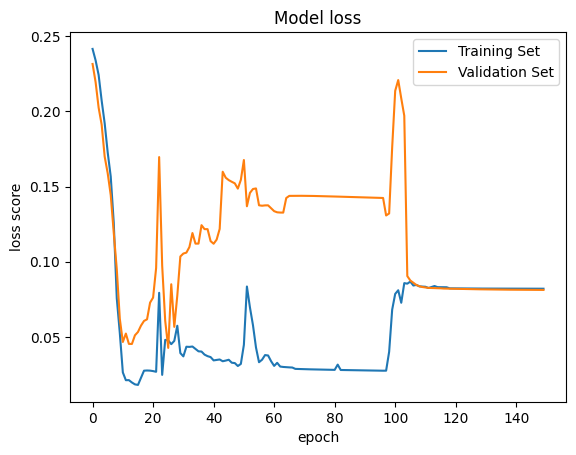

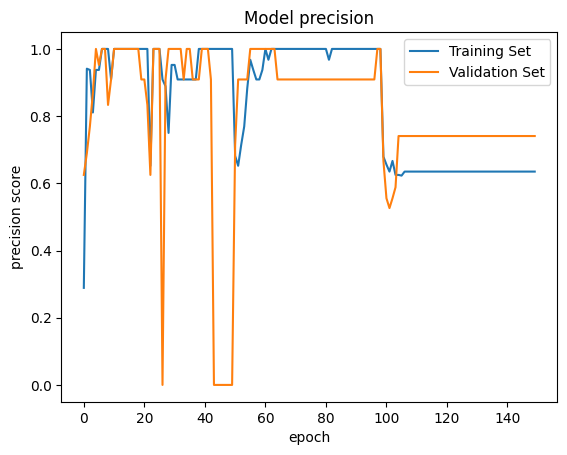

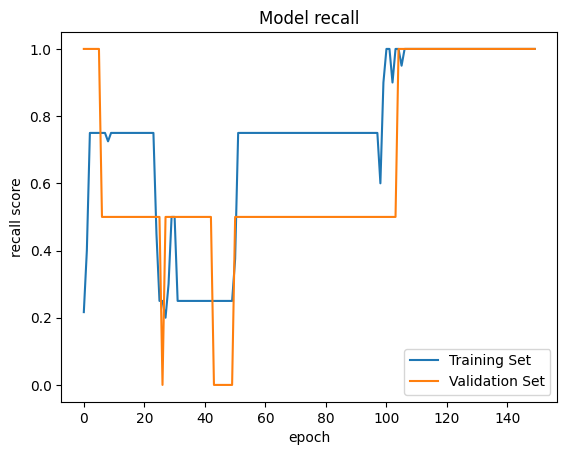

In [8]:
# Plots Performance Metrics during training and validation
history= best_model_F1Score['history']  # Get history object from dictionary
# Plot the loss and two metrics using the appropriate function
plot_training(history, type_graph='loss', saving=False)
plot_training(history, type_graph='precision', saving=False)
plot_training(history, type_graph='recall', saving=False)

Model evaluation over testing data

2/2 [==============================] - 0s 8ms/step


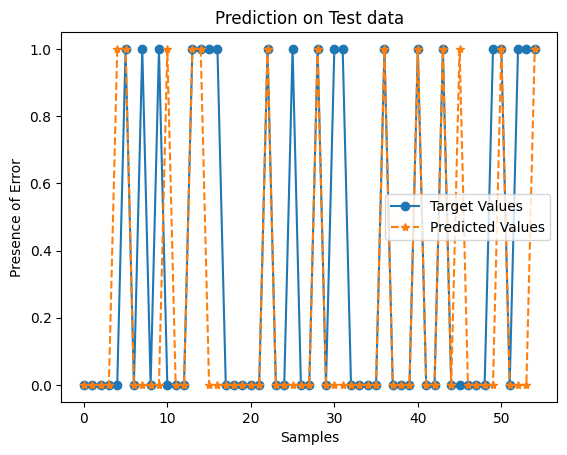

In [15]:
y_predicted_signal = best_model_F1Score['model'].predict(x_test_transformed)   # Get model predictions ove testing data
# Optimal threshold evaluation
right_predictions = 0  # variable to calculate the right predictions made by the model
for i in range(0, 100, 5): # evaluate thresholds between 0 and 1 with intervals of 0.05
    y_predicted = []  # List of binary predictions
    for j in range(len(y_predicted_signal)): # Iterate over the number of predictions made
        # Apply threshold
        if y_predicted_signal[j] > i/100:  
            y_predicted.append(1)
        else:
            y_predicted.append(0)
    # Evaluate how many right predictions are made (TP + TN)
    # Compare results with last obtained results
    if sum(y_predicted == y_test) > right_predictions: # If better
        right_predictions = sum(y_predicted==y_test)  # Update number of right predictions
        threshold = i/100  # Update threshold value
        
# Final list is obtained by filtered the predicted signal with the optimal obtained threshold
for j in range(len(y_predicted_signal)):
        if y_predicted_signal[j] > threshold:
            y_predicted [j] = 1
        else:
            y_predicted[j] = 0
            
# Plot the predictions and two metrics using the appropriate function
plot_prediction(y_predicted, y_test, saving=False)

In [12]:
# Print the obtained threshold and the number of right predictions made
print('Threshold:', threshold)
print('Correct Predictions:',sum(y_predicted == y_test))

Threshold: 0.45
Correct Predictions: 42


In [13]:
# Evaluate final performance over test data
f1_score_test = keras.metrics.F1Score()  # Import F1 Score metric from Keras
precision_test = keras.metrics.Precision()  # Import Precision Score metric from Keras
recall_test = keras.metrics.Recall()  # Import Recall Score metric from Keras
# Update the metrics giving as input the target and predicted arrays in a 2D shape
f1_score_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
precision_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
recall_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
# Print Results
print('Testing F1 Score: ', f1_score_test.result().numpy()[0])
print('Testing Precision: ', precision_test.result().numpy())
print('Testing Recall: ', recall_test.result().numpy())

Testing F1 Score:  0.60606056
Testing Precision:  0.7692308
Testing Recall:  0.5
